In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import matplotlib.pyplot as plt 
%matplotlib inline


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Reading Names Dataset
print(f"Working dir: {os.getcwd()}")
dataset_path = os.path.join(os.getcwd(), "../makemore/names.txt")
words = open(dataset_path, 'r').read().splitlines()

print(f"\nDataset cherry picking: {words[:8]}")
print(f"Dataset size: {len(words)}")

Working dir: /worxpace/workspace/zero-to-hero/zero_to_hero_homework/zero_to_hero_homework/exercises

Dataset cherry picking: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Dataset size: 32033


# Starter Code

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(f"Mapping index to string: {itos}")
vocabulary_size = len(itos)
print(f"Mapping size: {vocabulary_size}")


Mapping index to string: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Mapping size: 27


In [4]:
SEED = 42

block_size = 8 
dev_index = 0.8 #80% Training.
test_index = 0.9 #10% dev, 10% test.

# build the datasetc
def build_dataset(dataset = list, block_size = int):
  # block_size: context length, how many characters do we take to predict the next one?
  # returns: X as input features in size of contect length, Y as the labels.
  
  X, Y = [], []
  for w in dataset:
    
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
    
  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)
  print(f"Features: {X.shape}, {X.dtype}\nLabels: {Y.shape}, {Y.dtype}")
  return X, Y
  

# Split the dataset to train ; dev/validation ; test
random.seed(SEED) # Set seed for reproducibility
random.shuffle(words)


dev_dataset_index = int(dev_index*len(words))
test_dataset_index = int(test_index*len(words))

print("Train:")
Xtr, Ytr = build_dataset(words[:dev_dataset_index], block_size=block_size)
print("Dev:")
Xdev, Ydev = build_dataset(words[dev_dataset_index:test_dataset_index], block_size=block_size)
print("Test:")
Xte, Yte = build_dataset(words[test_dataset_index:], block_size=block_size)

Train:
Features: torch.Size([182625, 8]), torch.int64
Labels: torch.Size([182625]), torch.int64
Dev:
Features: torch.Size([22655, 8]), torch.int64
Labels: torch.Size([22655]), torch.int64
Test:
Features: torch.Size([22866, 8]), torch.int64
Labels: torch.Size([22866]), torch.int64


In [5]:
@torch.no_grad()
def split_loss(split, model):
    x, y = {
        "train": (Xtr, Ytr),
        "valid": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    return loss.item()

In [6]:
def sample(model):
    # sampling from the model
    for _ in range(20):
        out = []
        context = [0] * block_size
        while True:
            # Forward pass
            logits = model(torch.tensor([context]).to(device))
            probs = F.softmax(logits, dim = 1)

            ix = torch.multinomial(probs, num_samples = 1).item()

            # Shift the Context Window
            context = context[1:] + [ix]

            if ix == 0:
                break

            out.append(ix)
        
        print("".join(itos[i] for i in out))
        

# E01: using torch.nn Module instead of custom classes

- I commented the batchnorm parts since it (surprisingly) made the model worse
- the transpose lines before and after the batchnorm since the implementation of custom class `BatchNorm1d` in the original video has the input in format (N, L, C) instead of (N, C, L) as in the torch implementation

In [7]:
class FlattenConsecutive(nn.Module):
    def __init__(self, n):
        super().__init__()  # Initialize parent nn.Module class
        self.n = n
    
    def forward(self, x):
        B, T, C = x.shape  # B=batch size, T=sequence length, C=channels
        # Reshape while keeping 3D shape even when T//self.n == 1
        x = x.contiguous().view(B, T//self.n, C*self.n)
        return x
    
# Create a custom layer for transpose+batchnorm+transpose
class BatchNormWithTranspose(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.bn = nn.BatchNorm1d(n_hidden)
        
    def forward(self, x):
        # (N, L, C) -> (N, C, L)
        x = x.transpose(1, 2)
        x = self.bn(x)
        # (N, C, L) -> (N, L, C)
        x = x.transpose(1, 2)
        return x

In [8]:
class Model(nn.Module):
    def __init__(self, vocabulary_size, n_embed, n_hidden):
        super(Model, self).__init__()

        self.model = nn.Sequential(
            # Embedding
            nn.Embedding(vocabulary_size, n_embed),
            # block 1
            FlattenConsecutive(2), 
            nn.Linear(n_embed * 2, n_hidden, bias=False),
            #BatchNormWithTranspose(n_hidden),
            nn.Tanh(),
            # block 2
            FlattenConsecutive(2),
            nn.Linear(n_hidden * 2, n_hidden, bias=False),
            #BatchNormWithTranspose(n_hidden),
            nn.Tanh(),
            # block 3
            FlattenConsecutive(2),
            nn.Linear(n_hidden * 2, n_hidden, bias=False),
            #BatchNormWithTranspose(n_hidden),
            nn.Tanh(),
            # output
            nn.Linear(n_hidden, vocabulary_size, bias=False),
        )
        
    def weights_init(self):
        if isinstance(self.model, nn.Linear):
            nn.init.kaiming_normal_(self.model.weight, mode='fan_in', nonlinearity='tanh')

    def forward(self, x):
        x = self.model.forward(x)
        return x.squeeze(1)


# Init The Model, weights and Training
## E02: beating the 1.993 validation loss

In [9]:
n_embed = 32
n_hidden = 256

model = Model(vocabulary_size, n_embed, n_hidden).to(device)
model.weights_init()
model(Xtr[:10]);


In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
train_losses = []
dev_losses = []
batch_size = 64

for epoch in range(100):
    model.train()

    for i in range(0, len(Xtr), batch_size):
        x = Xtr[i:i+batch_size]
        y = Ytr[i:i+batch_size]

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    train_loss = split_loss('train', model)
    dev_loss = split_loss('valid', model)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    scheduler.step(dev_loss)

    print(f"epoch : {epoch} train_loss : {train_loss} dev_loss : {dev_loss}")

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


epoch : 0 train_loss : 2.377549171447754 dev_loss : 2.369610548019409
epoch : 1 train_loss : 2.2863473892211914 dev_loss : 2.282841444015503
epoch : 2 train_loss : 2.2423665523529053 dev_loss : 2.2434253692626953
epoch : 3 train_loss : 2.213505983352661 dev_loss : 2.2178421020507812
epoch : 4 train_loss : 2.1913397312164307 dev_loss : 2.1982297897338867
epoch : 5 train_loss : 2.1728572845458984 dev_loss : 2.182048797607422
epoch : 6 train_loss : 2.1568987369537354 dev_loss : 2.1682000160217285
epoch : 7 train_loss : 2.142775774002075 dev_loss : 2.155988931655884
epoch : 8 train_loss : 2.130016326904297 dev_loss : 2.1450185775756836
epoch : 9 train_loss : 2.1183106899261475 dev_loss : 2.1350607872009277
epoch : 10 train_loss : 2.107407808303833 dev_loss : 2.1259429454803467
epoch : 11 train_loss : 2.0971405506134033 dev_loss : 2.11751389503479
epoch : 12 train_loss : 2.0873630046844482 dev_loss : 2.1096537113189697
epoch : 13 train_loss : 2.077977180480957 dev_loss : 2.102271795272827
e

In [11]:
torch.save(model.state_dict(), "wave_net_bn_best_pth")

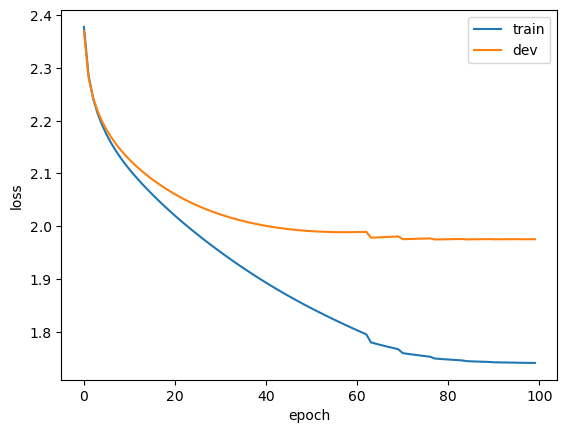

In [12]:
# plot train and dev losses
plt.plot(train_losses, label = 'train')
plt.plot(dev_losses, label = 'dev')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()

In [13]:
print(f"Training Loss: {split_loss('train', model):0.3f}")
print(f"Validation Loss: {split_loss('valid', model):0.3f}")
print(f"Test Loss: {split_loss('test', model):0.3f}")

Training Loss: 1.741
Validation Loss: 1.975
Test Loss: 1.981


In [14]:
sample(model)

henfiniti
mikenzie
jansel
bronathan
chelchel
franciel
mill
grahima
cair
marijancess
kacey
jaliah
kinleigh
atesani
eladie
kynzley
zylas
brene
finnon
malloria


# # E03: Using Convolutions

In [9]:
class ModelCnn(nn.Module):
    def __init__(self, vocab_size, n_embed, n_hidden, n_layers):
        super(ModelCnn, self).__init__()
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, n_embed)
        self.fc1 = nn.Linear(n_embed, n_hidden, bias=False)

        for i in range(n_layers):
            setattr(self, f"conv1d_{i}", nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden, kernel_size=2, stride=2, bias=False, dilation=1, padding=0))
            setattr(self, f"bn{i}", nn.BatchNorm1d(n_hidden))
    

        self.fc2 = nn.Linear(n_hidden, vocab_size, bias=False)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.fc1(x)
        x = F.tanh(x)
        x = x.transpose(1,2)

        for i in range(self.n_layers):
            conv1d = getattr(self, f"conv1d_{i}")
            bn = getattr(self, f"bn{i}")
            x = conv1d(x)

            x = bn(x)
            x = F.tanh(x)

        x = x.squeeze(-1)
        x = self.fc2(x)
        return x

In [19]:
n_embed = 25
n_hidden = 80

model = ModelCnn(vocab_size= vocab_size, n_embed= n_embed, n_hidden= n_hidden, n_layers= 3).to(device)
model(Xtr[:10]);
train_losses = []
dev_losses = []

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

for epoch in range(100):
    model.train()

    for i in range(0, len(Xtr), 64):
        x = Xtr[i:i+64]
        y = Ytr[i:i+64]

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    train_loss = split_loss('train', model)
    dev_loss = split_loss('valid', model)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    scheduler.step(dev_loss)

    print(f"epoch : {epoch} train_loss : {train_loss} dev_loss : {dev_loss}")

In [ ]:
# plot train and dev losses
plt.plot(train_losses, label = 'train')
plt.plot(dev_losses, label = 'dev')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()

In [ ]:
print(f"Training Loss: {split_loss('train', model):0.3f}")
print(f"Validation Loss: {split_loss('valid', model):0.3f}")
print(f"Test Loss: {split_loss('test', model):0.3f}")

In [ ]:
sample(model)